## Euroset
* 실습용 데이터

In [2]:
import tensorflow as tf
import numpy as np
import json
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [3]:
data_dir = 'dataset/'

tfds.load('eurosat/rgb', split=['train[:80%]','train[80%:]'],
          shuffle_files=True, # 내용을 섞어서 가져욤
          as_supervised=True, # 딕셔너리 형식으로 가져옴
          with_info=True, # 정보도 같이 가져옴
          data_dir=data_dir) # 가져올 위치

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27000 [00:00<?, ? examples/s]

Shuffling dataset/eurosat/rgb/2.0.0.incompleteNKC38O/eurosat-train.tfrecord*...:   0%|          | 0/27000 [00:…

Dataset eurosat downloaded and prepared to dataset/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.


([<PrefetchDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
  <PrefetchDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>],
 tfds.core.DatasetInfo(
     name='eurosat',
     full_name='eurosat/rgb/2.0.0',
     description="""
     EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
     bands and consisting of 10 classes with 27000 labeled and
     geo-referenced samples.
     
     Two datasets are offered:
     - rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
     - all: Contains all 13 bands in the original value range (float32).
     
     URL: https://github.com/phelber/eurosat
     """,
     config_description="""
     Sentinel-2 RGB channels
     """,
     homepage='https://github.com/phelber/eurosat',
     data_path='dataset/eurosat/rgb/2.0.0',
     file_format=tfr

In [4]:
data_dir = 'dataset/'

(train_ds,valid_ds),info = tfds.load('eurosat/rgb', split=['train[:80%]','train[80%:]'],
                                            shuffle_files=True, # 내용을 섞어서 가져욤
                                            as_supervised=True, # 딕셔너리 형식으로 가져옴
                                            with_info=True, # 정보도 같이 가져옴
                                            data_dir=data_dir) # 가져올 위치

In [5]:
train_ds,valid_ds

(<PrefetchDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>)

In [6]:
info

tfds.core.DatasetInfo(
    name='eurosat',
    full_name='eurosat/rgb/2.0.0',
    description="""
    EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
    bands and consisting of 10 classes with 27000 labeled and
    geo-referenced samples.
    
    Two datasets are offered:
    - rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
    - all: Contains all 13 bands in the original value range (float32).
    
    URL: https://github.com/phelber/eurosat
    """,
    config_description="""
    Sentinel-2 RGB channels
    """,
    homepage='https://github.com/phelber/eurosat',
    data_path='dataset/eurosat/rgb/2.0.0',
    file_format=tfrecord,
    download_size=89.91 MiB,
    dataset_size=89.50 MiB,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(64, 64, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('

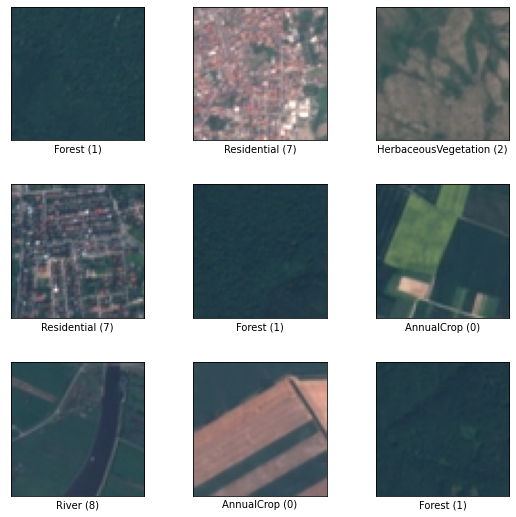

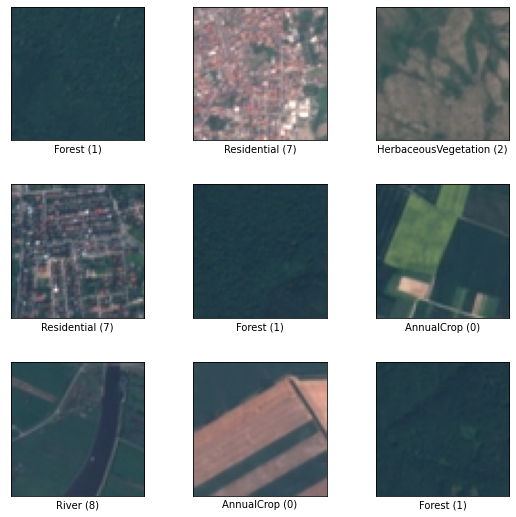

In [7]:
tfds.show_examples(train_ds,info)

,image,label
0,,5 (Pasture)
1,,7 (Residential)
2,,0 (AnnualCrop)
3,,1 (Forest)
4,,0 (AnnualCrop)

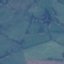
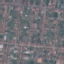
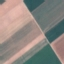
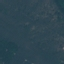
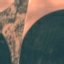

In [8]:
tfds.as_dataframe(valid_ds.take(5),info)

In [9]:
num_classes = info.features['label'].num_classes
num_classes

10

In [10]:
# 개별 데이터값 확인
print(info.features['label'].int2str(7))

Residential


In [11]:
batch_size=64 # 한번에 올리는 데이터 숫자
buffer_size=1000 # 미리 준비해두는 데이터 단위. 배치사이즈수량이 빠져나가면 다시 원데이터에서 같은 수량을 가져온다.

def preprocess_data(image,label):
  image = tf.cast(image,tf.float32)/255.
  return image, label

train_data = train_ds.map(preprocess_data,num_parallel_calls=tf.data.AUTOTUNE) # 오토튠은 데이터를 제공할 때 병렬처리를 해줌. 
valid_data = valid_ds.map(preprocess_data,num_parallel_calls=tf.data.AUTOTUNE)

train_data = train_data.shuffle(buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)
valid_data = valid_data.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE) # 섞을 필요가 없어 셔플 미사용.

In [12]:
from keras import Sequential
from keras.layers import Dense, Dropout, Flatten,Conv2D,MaxPooling2D,BatchNormalization

def build_model():
  model = Sequential([
      BatchNormalization(),
      Conv2D(32,(3,3), padding='same',activation='relu'),
      MaxPooling2D((2,2)),

      BatchNormalization(),
      Conv2D(64,(3,3), padding='same',activation='relu'),
      MaxPooling2D((2,2)),

      Flatten(),
      Dense(128,activation='relu'),
      Dropout(0.3),

      Dense(64,activation='relu'),
      Dropout(0.3),
      Dense(num_classes,activation='softmax')
  ])
  return model

model = build_model()

In [13]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['acc'])

In [14]:
history = model.fit(train_data,validation_data=valid_data,epochs=50)

Epoch 1/50
338/338 [==============================] - 15s 21ms/step - loss: 1.6741 - acc: 0.4277 - val_loss: 1.6587 - val_acc: 0.4246
Epoch 2/50
338/338 [==============================] - 4s 13ms/step - loss: 1.2652 - acc: 0.5557 - val_loss: 1.0137 - val_acc: 0.6717
Epoch 3/50
338/338 [==============================] - 4s 12ms/step - loss: 1.0971 - acc: 0.6121 - val_loss: 0.8198 - val_acc: 0.7293
Epoch 4/50
338/338 [==============================] - 4s 13ms/step - loss: 0.9839 - acc: 0.6553 - val_loss: 0.7896 - val_acc: 0.7341
Epoch 5/50
338/338 [==============================] - 4s 12ms/step - loss: 0.9075 - acc: 0.6840 - val_loss: 0.6642 - val_acc: 0.7793
Epoch 6/50
338/338 [==============================] - 4s 13ms/step - loss: 0.8436 - acc: 0.7126 - val_loss: 0.6745 - val_acc: 0.7681
Epoch 7/50
338/338 [==============================] - 4s 12ms/step - loss: 0.7838 - acc: 0.7348 - val_loss: 0.6896 - val_acc: 0.7776
Epoch 8/50
338/338 [==============================] - 4s 12ms/step -

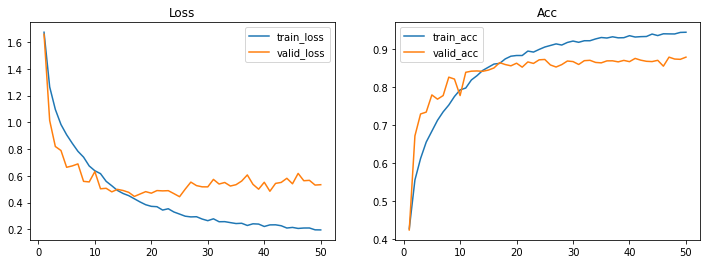

In [15]:
def plot_loss_acc(history,epoch):
  loss,val_loss = history.history['loss'],history.history['val_loss']
  acc,val_acc = history.history['acc'],history.history['val_acc']

  fig, axes = plt.subplots(1,2,figsize=(12,4))

  axes[0].plot(range(1, epoch+1), loss, label='train_loss')
  axes[0].plot(range(1, epoch+1), val_loss, label='valid_loss')
  axes[0].legend(loc='best')
  axes[0].set_title('Loss')

  axes[1].plot(range(1, epoch+1), acc, label='train_acc')
  axes[1].plot(range(1, epoch+1), val_acc, label='valid_acc')
  axes[1].legend(loc='best')
  axes[1].set_title('Acc')

  plt.show()

plot_loss_acc(history,50)

In [116]:
image_batch , label_batch = next(iter(train_data.take(1)))
image_batch.shape,label_batch.shape

(TensorShape([64, 64, 64, 3]), TensorShape([64]))

In [ ]:
image = image_batch[0]
label = label_batch[0].numpy()
image,label

Text(0.5, 1.0, 'Industrial')

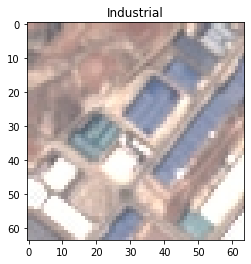

In [118]:
plt.imshow(image)
plt.title(info.features['label'].int2str(label))

In [119]:
def plot_augmentation(original,augmented):
  fig,axes = plt.subplots(1,2,figsize=(12,4))

  axes[0].imshow(original)
  axes[0].set_title('Original')

  axes[1].imshow(augmented)
  axes[1].set_title('Augmented')

plt.show()

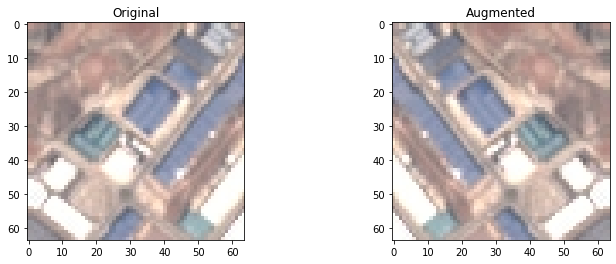

In [120]:
plot_augmentation(image,tf.image.flip_left_right(image))

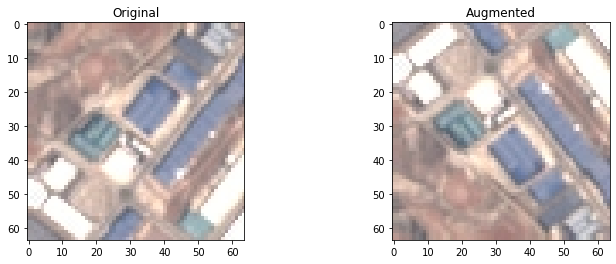

In [121]:
plot_augmentation(image,tf.image.flip_up_down(image))

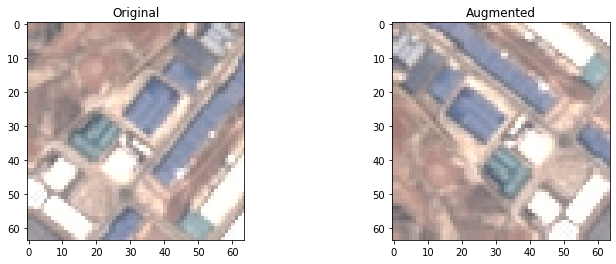

In [122]:
plot_augmentation(image,tf.image.rot90(image))

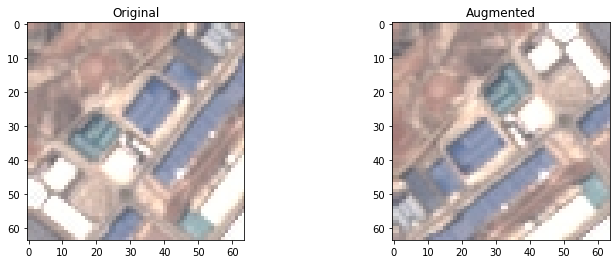

In [123]:
plot_augmentation(image,tf.image.transpose(image))

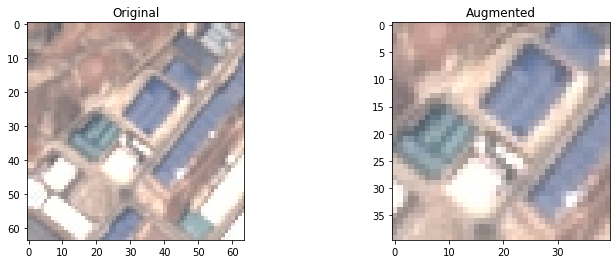

In [124]:
plot_augmentation(image,tf.image.central_crop(image,central_fraction=0.6))

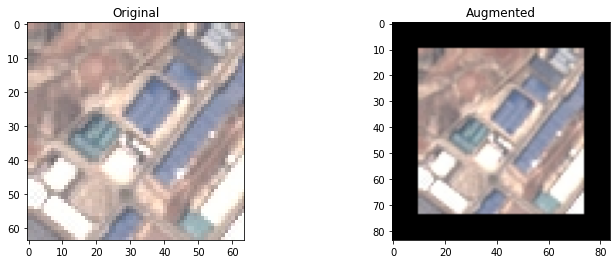

In [125]:
plot_augmentation(image,tf.image.resize_with_crop_or_pad(image, 64+20, 64+20))

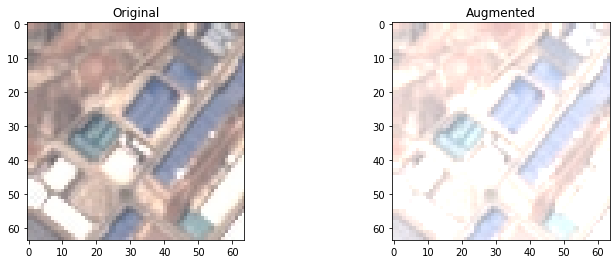

In [126]:
plot_augmentation(image,tf.image.adjust_brightness(image,0.3))

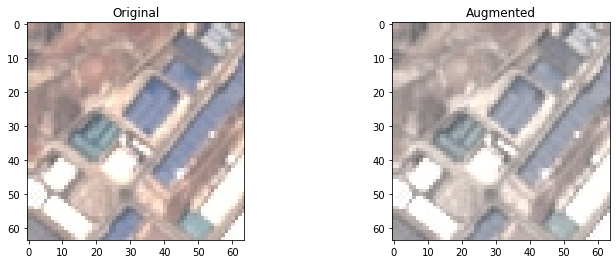

In [127]:
plot_augmentation(image,tf.image.adjust_saturation(image,0.5))

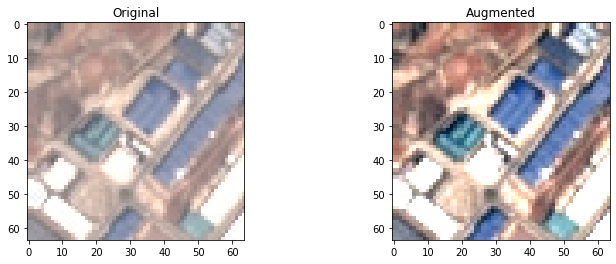

In [128]:
plot_augmentation(image,tf.image.adjust_contrast(image,2))

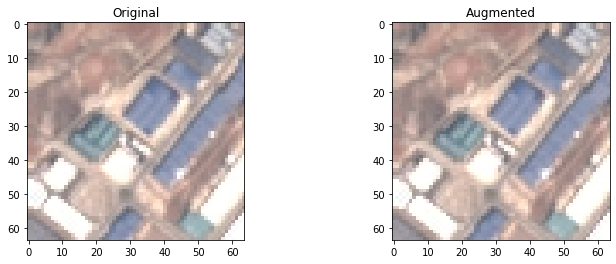

In [129]:
plot_augmentation(image,tf.image.random_crop(image,size=[64,64,3]))

In [130]:
batch_size=64
buffer_size = 1000

def preprocess_data(image,label):
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_flip_up_down(image)
  image = tf.image.random_brightness(image, max_delta=0.3)
  image = tf.image.random_contrast(image,0.5,1.5)
  image = tf.cast(image,tf.float32)/255.
  return image,label

train_aug = train_ds.map(preprocess_data,num_parallel_calls=tf.data.AUTOTUNE)
valid_aug = valid_ds.map(preprocess_data,num_parallel_calls=tf.data.AUTOTUNE)

train_aug = train_aug.shuffle(buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)
valid_aug = valid_aug.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)

Text(0.5, 1.0, 'River')

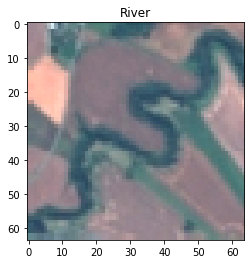

In [202]:
image_batch , label_batch = next(iter(train_aug.take(1)))
image_batch.shape,label_batch.shape

image = image_batch[0]
label = label_batch[0].numpy()
# image,label

plt.imshow(image)
plt.title(info.features['label'].int2str(label))

Epoch 1/50
338/338 [==============================] - 8s 22ms/step - loss: 2.0178 - acc: 0.2523 - val_loss: 1.7844 - val_acc: 0.3406
Epoch 2/50
338/338 [==============================] - 9s 25ms/step - loss: 1.7576 - acc: 0.3144 - val_loss: 1.5007 - val_acc: 0.4502
Epoch 3/50
338/338 [==============================] - 10s 27ms/step - loss: 1.6351 - acc: 0.3576 - val_loss: 1.4204 - val_acc: 0.4570
Epoch 4/50
338/338 [==============================] - 9s 26ms/step - loss: 1.5682 - acc: 0.3948 - val_loss: 1.3530 - val_acc: 0.5028
Epoch 5/50
338/338 [==============================] - 10s 29ms/step - loss: 1.4914 - acc: 0.4258 - val_loss: 1.3627 - val_acc: 0.4920
Epoch 6/50
338/338 [==============================] - 9s 27ms/step - loss: 1.4411 - acc: 0.4500 - val_loss: 1.2386 - val_acc: 0.5441
Epoch 7/50
338/338 [==============================] - 14s 37ms/step - loss: 1.3866 - acc: 0.4750 - val_loss: 1.2053 - val_acc: 0.5496
Epoch 8/50
338/338 [==============================] - 11s 30ms/ste

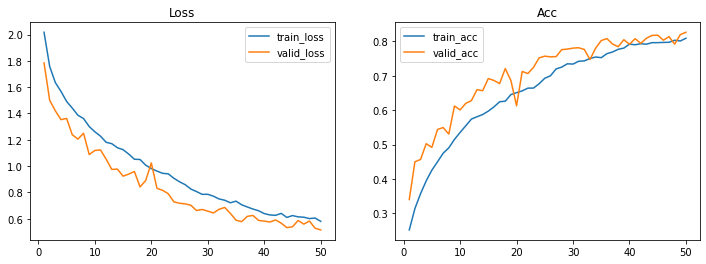

In [204]:
aug_model = build_model()
aug_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['acc'])
aug_history = aug_model.fit(train_aug,validation_data=valid_aug,epochs=50)
plot_loss_acc(aug_history,50)

In [210]:
from keras.applications import ResNet50V2
from keras.utils import plot_model

pre_trained_base = ResNet50V2(include_top=False,input_shape=[64,64,3])
pre_trained_base.trainable = False
plot_model(pre_trained_base,show_shapes=True,show_layer_names=True)

Output hidden; open in https://colab.research.google.com to view.

In [211]:
def build_transfer_model():
  model = Sequential([
      pre_trained_base,

      Flatten(),
      Dense(128,activation='relu'),
      Dropout(0.3),

      Dense(64,activation='relu'),
      Dropout(0.3),
      Dense(num_classes,activation='softmax')
  ])
  return model

In [212]:
t_model = build_transfer_model()
t_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2, 2, 2048)        23564800  
                                                                 
 flatten_3 (Flatten)         (None, 8192)              0         
                                                                 
 dense_9 (Dense)             (None, 128)               1048704   
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 10)               

Epoch 1/50
338/338 [==============================] - 17s 35ms/step - loss: 1.1214 - acc: 0.6397 - val_loss: 0.6685 - val_acc: 0.7769
Epoch 2/50
338/338 [==============================] - 10s 30ms/step - loss: 0.7960 - acc: 0.7432 - val_loss: 0.5797 - val_acc: 0.8081
Epoch 3/50
338/338 [==============================] - 10s 30ms/step - loss: 0.7125 - acc: 0.7693 - val_loss: 0.5438 - val_acc: 0.8154
Epoch 4/50
338/338 [==============================] - 11s 31ms/step - loss: 0.6593 - acc: 0.7852 - val_loss: 0.5251 - val_acc: 0.8220
Epoch 5/50
338/338 [==============================] - 11s 33ms/step - loss: 0.6299 - acc: 0.7945 - val_loss: 0.5116 - val_acc: 0.8239
Epoch 6/50
338/338 [==============================] - 11s 31ms/step - loss: 0.6072 - acc: 0.8009 - val_loss: 0.5073 - val_acc: 0.8309
Epoch 7/50
338/338 [==============================] - 10s 30ms/step - loss: 0.5837 - acc: 0.8077 - val_loss: 0.4921 - val_acc: 0.8319
Epoch 8/50
338/338 [==============================] - 10s 30ms

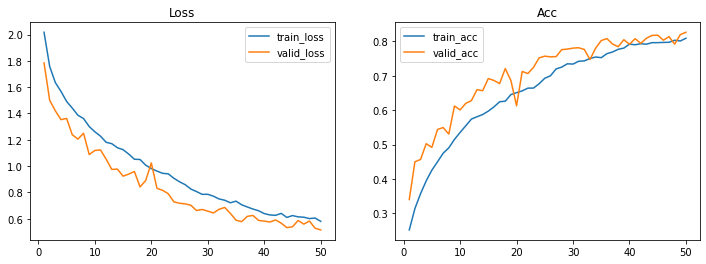

In [213]:
t_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['acc'])
t_history = t_model.fit(train_aug,validation_data=valid_aug,epochs=50)
plot_loss_acc(aug_history,50)

In [214]:
pred = t_model.predict(image.numpy().reshape(-1,64,64,3))
pred

1/1 [==============================] - 2s 2s/step


array([[6.0538650e-03, 2.8989831e-05, 8.7860419e-04, 3.2317329e-02,
        1.4384495e-05, 2.2318615e-02, 2.9983968e-04, 7.3251408e-07,
        9.3794680e-01, 1.4082357e-04]], dtype=float32)